<a href="https://colab.research.google.com/github/Frkntf/DATA4auditors_IAEMetz/blob/main/Projetpr%C3%A9sentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# BLOCK : IMPORT
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Définir les tickers des actions et du benchmark
tickers = ["AAPL", "MSFT", "META"]
benchmark_ticker = "SPY" #SPDR S&P 500 ETF Trust

# Définir la période d'analyse
start_date = "2019-03-12"
end_date   = "2025-03-12"

# Télécharger les données
data = yf.download(tickers, start=start_date, end=end_date)
benchmark_data = yf.download(benchmark_ticker, start=start_date, end=end_date)

# Sélectionner uniquement les prix de clôture avec xs() pour éviter le MultiIndex
data = data.xs("Close", level="Price", axis=1)
benchmark_data = benchmark_data.xs("Close", level="Price", axis=1)

# Vérifier l'affichage après correction
print("Colonnes des actions:", data.columns)
print("Colonnes du benchmark:", benchmark_data.columns)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  1 of 1 completed

Colonnes des actions: Index(['AAPL', 'META', 'MSFT'], dtype='object', name='Ticker')
Colonnes du benchmark: Index(['SPY'], dtype='object', name='Ticker')


In [3]:
# Calculer les rendements journaliers pour les actions et le benchmark
returns = data.pct_change().dropna()
benchmark_returns = benchmark_data.pct_change().dropna()

# Aligner les indices pour s'assurer d'utiliser les mêmes dates
returns = returns.loc[benchmark_returns.index]

# Calcul des rendements moyens annualisés et de la volatilité annualisée
mean_returns = returns.mean() * 252       # Rendement annualisé
volatility   = returns.std() * np.sqrt(252) # Volatilité annualisée

# Taux sans risque annuel (exemple : 1%)
risk_free_rate = 0.02

print("\nAnalyse des actions par rapport au benchmark SPY\n")


Analyse des actions par rapport au benchmark SPY



In [4]:
# Initialiser performance_table avant la boucle
performance_table = []


for stock in tickers:
    # Vérification des données pour éviter les erreurs
    if stock not in returns.columns:
        print(f"⚠️ Données indisponibles pour {stock}")
        continue

    # Conversion des séries pandas en tableaux numpy pour éviter les erreurs de dimensions
    x = benchmark_returns.values.flatten()  # Benchmark SPY
    y = returns[stock].values.flatten()  # Action spécifique

    # Calcul de beta et de l'alpha journalier via une régression linéaire
    beta, daily_alpha = np.polyfit(x, y, 1)
    annual_alpha = daily_alpha * 252  # Annualisation de l'alpha

    # Calcul du ratio de Sharpe
    sharpe_ratio = (mean_returns[stock] - risk_free_rate) / volatility[stock]

    print(f"{stock}:")
    print(f"  Rendement annuel   = {mean_returns[stock]:.2%}")
    print(f"  Volatilité annuelle = {volatility[stock]:.2%}")
    print(f"  Beta              = {beta:.2f}")
    print(f"  Alpha annualisé   = {annual_alpha:.2%}")
    print(f"  Ratio de Sharpe   = {sharpe_ratio:.2f}\n")

      # Ajouter les résultats dans le tableau après les calculs pour chaque stock
    performance_table.append([stock, mean_returns[stock], volatility[stock], beta, annual_alpha, sharpe_ratio])


AAPL:
  Rendement annuel   = 31.92%
  Volatilité annuelle = 30.66%
  Beta              = 1.20
  Alpha annualisé   = 13.87%
  Ratio de Sharpe   = 0.98

MSFT:
  Rendement annuel   = 25.38%
  Volatilité annuelle = 29.08%
  Beta              = 1.19
  Alpha annualisé   = 7.44%
  Ratio de Sharpe   = 0.80

META:
  Rendement annuel   = 30.21%
  Volatilité annuelle = 42.38%
  Beta              = 1.32
  Alpha annualisé   = 10.36%
  Ratio de Sharpe   = 0.67



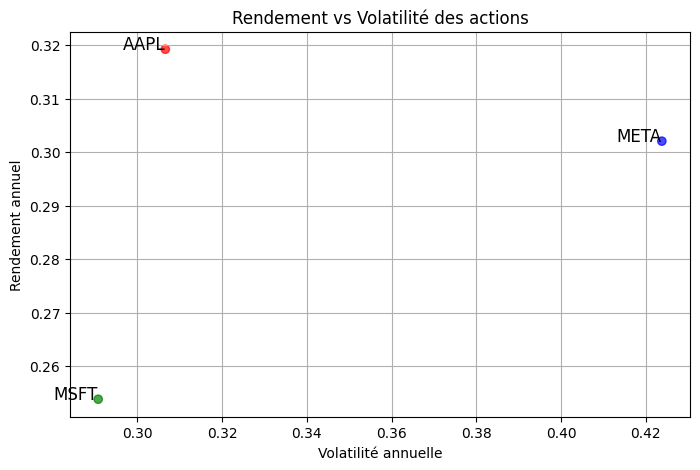

In [5]:
# Tracé du rendement vs volatilité pour visualiser la performance
plt.figure(figsize=(8, 5))
colors = {"AAPL": "red", "MSFT": "blue", "META": "green"}
plt.scatter(volatility, mean_returns, color=[colors[t] for t in tickers if t in returns.columns], alpha=0.7)

# Annotation des points
for stock in tickers:
    if stock in returns.columns:
        plt.text(volatility[stock], mean_returns[stock], stock, fontsize=12, ha='right')

plt.xlabel("Volatilité annuelle")
plt.ylabel("Rendement annuel")
plt.title("Rendement vs Volatilité des actions")
plt.grid(True)
plt.show()


         Return  Volatility      Beta     Alpha  Sharpe Ratio
Stock                                                        
AAPL   0.319224    0.306590  1.198666  0.138738      0.975976
MSFT   0.253844    0.290751  1.191684  0.074409      0.804276
META   0.302052    0.423780  1.317719  0.103640      0.665563


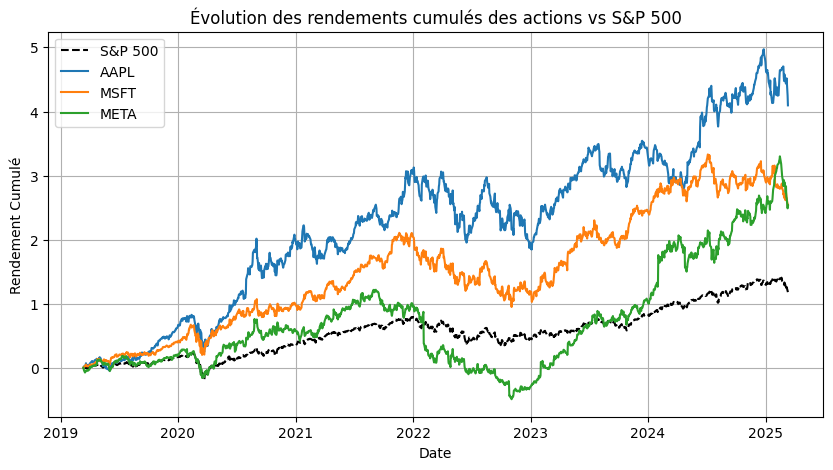

In [6]:
# Création du DataFrame de performance
performance_df = pd.DataFrame(performance_table, columns=["Stock", "Return", "Volatility", "Beta", "Alpha", "Sharpe Ratio"])
performance_df.set_index("Stock", inplace=True)

# Affichage du tableau de performances
print(performance_df)


# Rendements cumulés
cumulative_returns = (1 + returns).cumprod() - 1
cumulative_benchmark = (1 + benchmark_returns).cumprod() - 1


# Affichage des courbes de rendement cumulé
plt.figure(figsize=(10, 5))
plt.plot(cumulative_benchmark, label="S&P 500", linestyle="dashed", color="black")
for stock in tickers:
    if stock in cumulative_returns.columns:
        plt.plot(cumulative_returns[stock], label=stock)

plt.xlabel("Date")
plt.ylabel("Rendement Cumulé")
plt.title("Évolution des rendements cumulés des actions vs S&P 500")
plt.legend()
plt.grid(True)
plt.show()

<Figure size 1200x600 with 0 Axes>

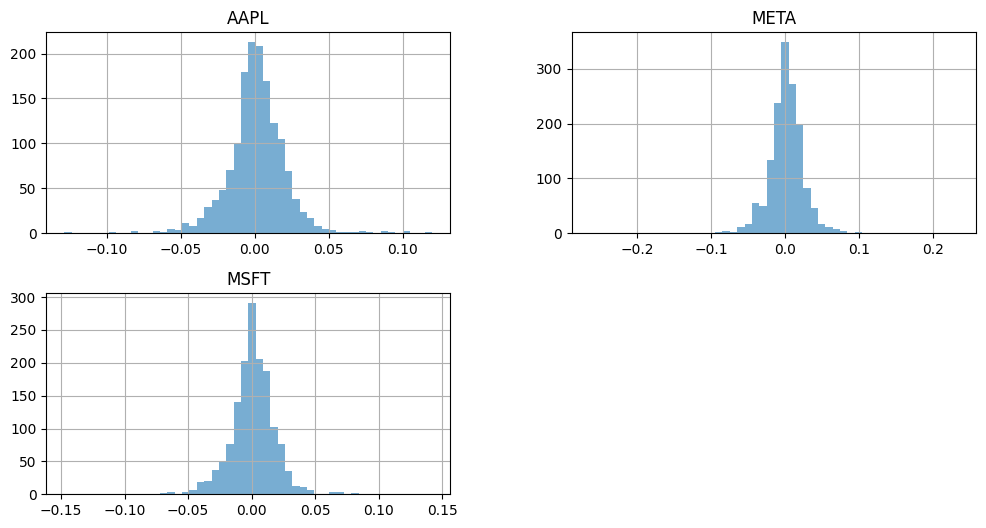

In [7]:
# Histogramme des rendements quotidiens
plt.figure(figsize=(12,6))
returns.hist(bins=50, alpha=0.6, figsize=(12,6))
plt.title("Distribution des rendements quotidiens")
plt.show()

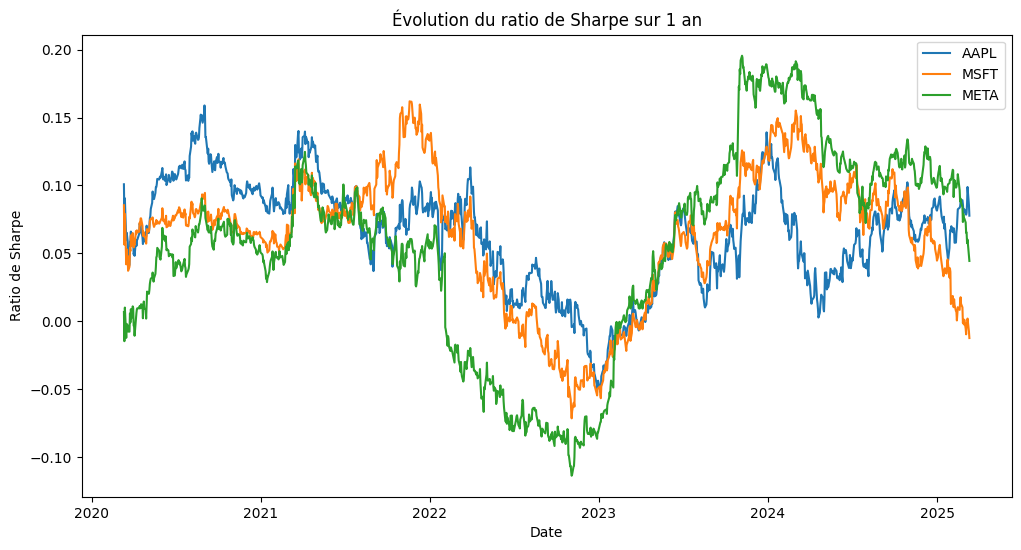

In [9]:
# Rolling Sharpe Ratio
rolling_sharpe = returns.rolling(window=252).mean() / returns.rolling(window=252).std()
plt.figure(figsize=(12, 6))
for stock in tickers:
    if stock in rolling_sharpe.columns:
        plt.plot(rolling_sharpe[stock], label=stock)  # Correction d'indentation

plt.xlabel("Date")
plt.ylabel("Ratio de Sharpe")
plt.title("Évolution du ratio de Sharpe sur 1 an")
plt.legend()
plt.show()

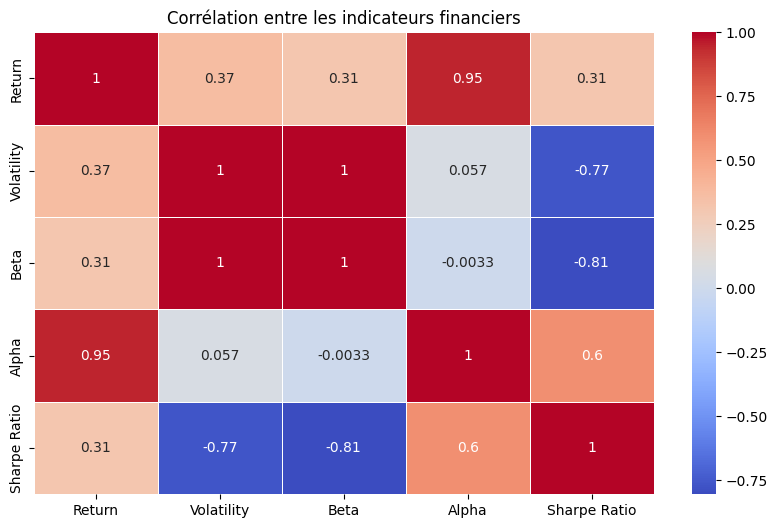

In [8]:
# Heatmap des corrélations entre ratios financiers ++++
plt.figure(figsize=(10, 6))
sns.heatmap(performance_df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Corrélation entre les indicateurs financiers")
plt.show()